In [2]:
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200)
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
merge = pd.read_csv("C:/Users/Nasibullah Qarizada/Desktop/data2.csv")

In [4]:
#merge.drop( 'Unnamed: 0' ,axis= 1 ,inplace= True )
#merge.drop( 'tokenized' ,axis= 1 ,inplace= True )

In [5]:
merge.shape

(10005, 8)

In [6]:
merge["sentiment"].value_counts()

-1    5566
 1    4439
Name: sentiment, dtype: int64

In [7]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(merge['clean_tweet'])

In [8]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(merge['clean_tweet'])

In [9]:
tokenized_tweet = merge['clean_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(merge['clean_tweet']), epochs=20)

(3129780, 3872580)

In [10]:
model_w2v.wv.most_similar(positive="sick")

[('w/Covid', 0.4715258777141571),
 ('6/', 0.4557725191116333),
 ('sword', 0.45510220527648926),
 ('“allergies”', 0.4532407522201538),
 ('employed', 0.45049095153808594),
 ('superspreaders', 0.4478979706764221),
 ('5+', 0.4468364715576172),
 ('Infants', 0.4447093904018402),
 ('counterproductive', 0.44310784339904785),
 ('again…', 0.44105780124664307)]

In [11]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [12]:
merge

,Unnamed: 0,tweet,clean_tweet,tokenized,sentiment_results,polarity,subjectivity,sentiment
0,0,Maybe people would take Covid more seriously if it was as physically evident as chickenpox or measles. Both are contagious. You can’t just walk around with chickenpox infecting others at work or s...,Maybe people Covid seriously physically evident chickenpox measles contagious can’t walk chickenpox infecting work school long Covid thing,"['Maybe', 'people', 'Covid', 'seriously', 'physically', 'evident', 'chickenpox', 'measles', 'contagious', 'can’t', 'walk', 'chickenpox', 'infecting', 'work', 'school', 'long', 'Covid', 'thing']","{'polarity': 0.1, 'subjectivity': 0.325, 'sentiment': '1'}",0.100000,0.325000,1
1,1,@DaphneSheaves Funny . Not me . Just back after my brief spell with covid . First day back in the office . But was able from from home . I’m like no . I don’t want to stay home again . Tired of t...,Funny brief spell covid day office able home I’m like don’t want stay home Tired lockdowns / head colds / schools closed / isolation ask week Enjoy,"['Funny', 'brief', 'spell', 'covid', 'day', 'office', 'able', 'home', 'I’m', 'like', 'don’t', 'want', 'stay', 'home', 'Tired', 'lockdowns', '/', 'head', 'colds', '/', 'schools', 'closed', '/', 'is...","{'polarity': 0.10833333333333334, 'subjectivity': 0.5430555555555555, 'sentiment': '1'}",0.108333,0.543056,1
2,2,@0ld_School_ @komonews Well what the F did you ever do before covid! Brain washed koolaid drinking I D I O T'S !,F covid Brain washed koolaid drinking TS,"['F', 'covid', 'Brain', 'washed', 'koolaid', 'drinking', 'TS']","{'polarity': 0.0, 'subjectivity': 0.0, 'sentiment': '-1'}",0.000000,0.000000,-1
3,3,Los Angeles Times: California lawmaker scraps plan to require COVID-19 vaccinations for school children.,Los Angeles Times: California lawmaker scraps plan require COVID19 vaccinations school children,"['Los', 'Angeles', 'Times:', 'California', 'lawmaker', 'scraps', 'plan', 'require', 'COVID19', 'vaccinations', 'school', 'children']","{'polarity': 0.0, 'subjectivity': 0.0, 'sentiment': '-1'}",0.000000,0.000000,-1
4,4,"@D_Bone Believe it’s airborne. And often these “I went nowhere” people either got grocery, got gas, have kids who went to school, live in an apartment/townhouse, or have someone else who live in t...",Believe it’s airborne “I went nowhere” people got grocery got gas kids went school live apartment/townhouse live home like flu sit surface minute surely Covid,"['Believe', 'it’s', 'airborne', '“I', 'went', 'nowhere”', 'people', 'got', 'grocery', 'got', 'gas', 'kids', 'went', 'school', 'live', 'apartment/townhouse', 'live', 'home', 'like', 'flu', 'sit', '...","{'polarity': 0.25757575757575757, 'subjectivity': 0.6296296296296297, 'sentiment': '1'}",0.257576,0.629630,1
...,...,...,...,...,...,...,...,...
10000,10000,@shplinters @EssexPR A study done by Johns Hopkins university found that lockdowns - including stay-at-home orders and school closures - only lowered COVID deaths by 0.2 percent overall. They conc...,study Johns Hopkins university found lockdowns including stayathome orders school closures lowered COVID deaths 02 percent overall concluded lockdowns caused damage repeated,"['study', 'Johns', 'Hopkins', 'university', 'found', 'lockdowns', 'including', 'stayathome', 'orders', 'school', 'closures', 'lowered', 'COVID', 'deaths', '02', 'percent', 'overall', 'concluded', ...","{'polarity': 0.0, 'subjectivity': 0.0, 'sentiment': '-1'}",0.000000,0.000000,-1
10001,10001,"@PplsCityCouncil @avitale @kennethmejiaLA @FilmThePoliceLA @BLMLA @KtownforAll @theglowingstars @GinaForLA @ALforLA2022 @YouthJusticeLA @NiggaTheory @stoplapdspying The allocation of all monies, C...",allocation monies Covid relief directed deterrence crime increasing number police streets stop Direct money early childhood education childcare school programs…,"['allocation', 'monies', 'Covid', 'relief', 'directed', 'deterrence', 'crime', 'increasing', 'number', 'police', 'streets', 'stop', 'Direct', 'm

In [13]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(10005, 200)

In [14]:
tqdm.pandas(desc="progress-bar")

In [15]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

In [16]:
labeled_tweets = add_label(tokenized_tweet) # label all the tweets

In [17]:
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

100%|██████████| 10005/10005 [00:00<00:00, 2016918.75it/s]


In [18]:
model_d2v.train(labeled_tweets, total_examples= len(merge['clean_tweet']), epochs=15)

In [19]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(merge)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))
    
docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape

(10005, 200)

In [20]:
MODEL_ID = []
Accuracy = []
LOG_CV_ERR = []
F1Score = []
def calculate_log_cv_error(logmodel,X_train,y_train):
    ms_errors= cross_val_score(logmodel, X_train, y_train, cv=5, scoring = make_scorer(mean_squared_error))
    rms_errors = np.sqrt(ms_errors)
    mean_rms_error = rms_errors.mean()
    return mean_rms_error

In [21]:
def evaluate_model(logmodel,X_train,X_test,y_train,y_test,predictions):
   
    print(f'\nClassification Report:\n{classification_report(y_test,predictions)}')
    print('')
    print(f'\nConfusion Matrix:\n{confusion_matrix(y_test,predictions)}')
    print('')
    print (f'\nAccuracy Score:  {accuracy_score(y_test,predictions)}')
    logit_roc_auc = roc_auc_score(y_test, logmodel.predict(X_test), multi_class = 'ovr')
    fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])
    
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [22]:
bow.shape

(10005, 1000)

Logistic regression

In [23]:
#bag of words

train_bow = bow[:10005,:]
test_bow = bow[10005:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, merge['sentiment'],  
                                                          random_state=42, 
                                                          test_size=0.3)

In [24]:
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

F1_Score = f1_score(yvalid, prediction_int, average='micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.3887408394403731


In [25]:
#tf-idf features
train_tfidf = tfidf[:10005,:]
test_tfidf = tfidf[10005:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

In [26]:
lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int, average='micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.4173884077281812


In [27]:
#Word2Vec
train_w2v = wordvec_df.iloc[:10005,:]
test_w2v = wordvec_df.iloc[10005:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

In [28]:
lreg.fit(xtrain_w2v, ytrain)

prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int, average='micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.45403064623584277



Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1631
           0       0.00      0.00      0.00         0
           1       0.47      0.99      0.64      1371

    accuracy                           0.45      3002
   macro avg       0.16      0.33      0.21      3002
weighted avg       0.21      0.45      0.29      3002



Confusion Matrix:
[[   0   82 1549]
 [   0    0    0]
 [   0    8 1363]]


Accuracy Score:  0.45403064623584277


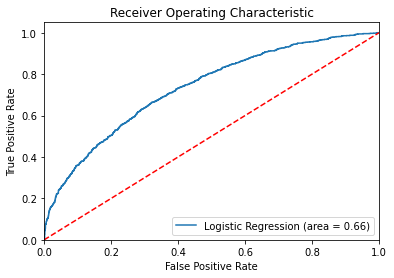

In [29]:
evaluate_model(lreg,xtrain_w2v,xvalid_w2v,ytrain,yvalid,prediction_int)
MODEL_ID.append('Logistic Regression')
Accuracy.append(accuracy_score(yvalid, prediction_int))
F1Score.append(f1_score(yvalid, prediction_int, average = 'micro'))

In [30]:
#doc2vec
train_d2v = docvec_df.iloc[:10005,:]
test_d2v = docvec_df.iloc[10005:,:]

xtrain_d2v = train_d2v.iloc[ytrain.index,:]
xvalid_d2v = train_d2v.iloc[yvalid.index,:]

In [31]:
lreg.fit(xtrain_d2v, ytrain)

prediction = lreg.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int, average='micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.3984010659560293


Naive Bayes

In [32]:
#bag of words
model = BernoulliNB()

model.fit(xtrain_bow, ytrain) # training the model

prediction = model.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

F1_Score = f1_score(yvalid, prediction_int, average='micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.39407061958694206


In [33]:
#TF-IDF
model.fit(xtrain_tfidf, ytrain)

prediction = model.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int, average='micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.39407061958694206


In [34]:
#word2vec
model.fit(xtrain_w2v, ytrain)

prediction = model.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int, average='micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.36675549633577614



Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1631
           0       0.00      0.00      0.00         0
           1       0.52      0.80      0.63      1371

    accuracy                           0.37      3002
   macro avg       0.17      0.27      0.21      3002
weighted avg       0.24      0.37      0.29      3002



Confusion Matrix:
[[   0  616 1015]
 [   0    0    0]
 [   0  270 1101]]


Accuracy Score:  0.36675549633577614


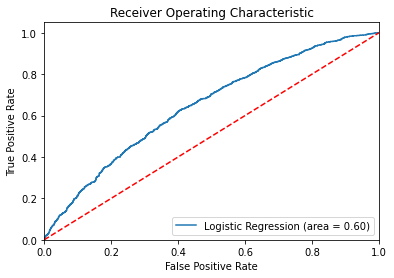

In [35]:
evaluate_model(model,xtrain_tfidf,xvalid_tfidf,ytrain,yvalid,prediction_int)
MODEL_ID.append('Naive Bayes')
Accuracy.append(accuracy_score(yvalid, prediction_int))
F1Score.append(f1_score(yvalid, prediction_int, average = 'micro'))

In [36]:
#doc2vec
model.fit(xtrain_d2v, ytrain)

prediction = model.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int, average='micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.33777481678880744


suppoert vector machine

In [37]:
#bag of words
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain)

prediction = svc.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int, average='micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.391072618254497


In [39]:
#tfidf
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain)

prediction = svc.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int, average = 'micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.39407061958694206


In [40]:
#word2vec
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain)

prediction = svc.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int, average = 'micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.3970686209193871



Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1631
           0       0.00      0.00      0.00         0
           1       0.55      0.87      0.67      1371

    accuracy                           0.40      3002
   macro avg       0.18      0.29      0.22      3002
weighted avg       0.25      0.40      0.31      3002



Confusion Matrix:
[[   0  641  990]
 [   0    0    0]
 [   0  179 1192]]


Accuracy Score:  0.39706862091938705


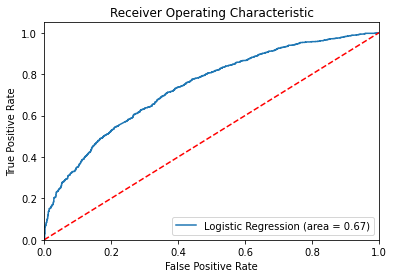

In [41]:
evaluate_model(svc,xtrain_w2v,xvalid_w2v,ytrain,yvalid,prediction_int)
MODEL_ID.append('Support Vector Classifier')
Accuracy.append(accuracy_score(yvalid, prediction_int))
F1Score.append(f1_score(yvalid, prediction_int, average = 'micro'))

In [42]:
#doc2vec
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_d2v, ytrain)

prediction = svc.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int, average = 'micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.3987341772151899


random forest

In [43]:
#bag of words
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain)

prediction = rf.predict(xvalid_bow)
F1_Score = f1_score(yvalid, prediction, average = 'micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.8207861425716189


In [44]:
#tf-idf
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain)

prediction = rf.predict(xvalid_tfidf)
F1_Score = f1_score(yvalid, prediction, average = 'micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.8181212524983345


In [45]:
#word2vec
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain)

prediction = rf.predict(xvalid_w2v)
F1_Score = f1_score(yvalid, prediction, average = 'micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.6508994003997335



Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.86      0.73      1631
           1       0.71      0.40      0.51      1371

    accuracy                           0.65      3002
   macro avg       0.67      0.63      0.62      3002
weighted avg       0.67      0.65      0.63      3002



Confusion Matrix:
[[1410  221]
 [ 827  544]]


Accuracy Score:  0.6508994003997335


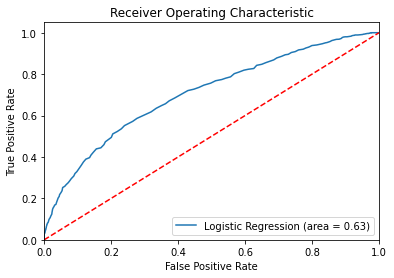

In [46]:
evaluate_model(rf,xtrain_bow,xvalid_bow,ytrain,yvalid,prediction)
MODEL_ID.append('Random Forest CLassifier')
Accuracy.append(accuracy_score(yvalid, prediction))
F1Score.append(f1_score(yvalid, prediction, average = 'micro'))

In [47]:
#doc2vec
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_d2v, ytrain)

prediction = rf.predict(xvalid_d2v)
F1_Score = f1_score(yvalid, prediction, average = 'micro') # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.6215856095936043


In [48]:
leaderboard = pd.DataFrame({'Model_ID':MODEL_ID, 'F1Score':F1Score,'Accuracy':Accuracy})
leaderboard

,Model_ID,F1Score,Accuracy
0,Logistic Regression,0.454031,0.454031
1,Naive Bayes,0.366755,0.366755
2,Support Vector Classifier,0.397069,0.397069
3,Random Forest CLassifier,0.650899,0.650899
